In [2]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import time
import numpy as np
from scipy import interpolate
from scipy.signal import find_peaks
import trackpy as tp
import scipy as sc
import matplotlib.colors as colors
import os
from ipywidgets import HBox, Textarea, interact

%matplotlib inline
def l2n(x): 
    return np.asarray(x)
plt.style.use('dark_background')

params = {'legend.fontsize': 22,
          'figure.figsize': (8, 6),
         'axes.labelsize': 24,
         'axes.titlesize':24,
         'xtick.labelsize':22,
         'ytick.labelsize':22}
plt.rcParams.update(params)
plt.rc('xtick',labelsize=22)
plt.rc('ytick',labelsize=22)


In [3]:
def _autoCorr(v,maxLag):
    vac = np.zeros(maxLag) #initialize the correlation function
    vMag = np.sum(np.sqrt(v*v),axis=0) #velocity magnitudes
    
    vac[0] = np.mean( np.sum( v*v ,axis=0)/(vMag*vMag));

    for tau in range(1,maxLag):            
        vac[tau] = np.mean( np.sum( v[:,tau:]*v[:,:-tau]/(vMag[tau:]*vMag[:-tau]) ,axis=0));
  
    return vac

def velocityTimeAutoCorrelation(t,r,maxLag=10):
    #Return the autocorelation of an instanteneous veolocity 
    #t - time, x - a position vector
    maxLag = min(maxLag,len(t)-1)

    tt = np.zeros(r.shape[0])+t[:,None]
    tt = tt.T
    v = np.diff(r)/np.diff(tt)

    vac = _autoCorr(v,maxLag)
    return vac

def calcInstantaneousCurvature(r):
    
    #calculates the local curvature at every point
    #r is a vector array of location
    
    #calculate difference between positions 3&1 and 2&1
    a = (np.roll(r,-2)-r)[:,:-2]
    b = (np.roll(r,-1)-r)[:,:-2]
    aNorm = np.linalg.norm(a)
    bNorm = np.linalg.norm(b)
    sinTheta = np.cross(a,b,axis=0)/(aNorm*bNorm)

    R = (a-b)/(2*sinTheta)

    return R


def calcWindowVectorCurvature(r,halfWindow=1):
    
    window=halfWindow*2
    
    #calculates the local curvature at every point
    #r is a vector array of location
    
    #calculate difference between positions 3&1 and 2&1
    a = (np.roll(r,-window)-r)[:,:-window]
    b = (np.roll(r,-halfWindow)-r)[:,:-window]
    aNorm = np.linalg.norm(a,axis=0)
    bNorm = np.linalg.norm(b,axis=0)
    sinTheta = np.cross(a,b,axis=0)/(aNorm*bNorm)

    R = (a-b)/(2*sinTheta)

    return R

def calcWindowScalarCurvature(r,halfWindow=1):
    
    window=halfWindow*2
    
    #calculates the local curvature at every point
    #r is a vector array of location
    
    #calculate difference between positions 3&1 and 2&1
    a = (np.roll(r,-window)-r)[:,:-window]
    b = (np.roll(r,-halfWindow)-r)[:,:-window]
    aNorm = np.linalg.norm(a,axis=0)
    bNorm = np.linalg.norm(b,axis=0)
    sinTheta = np.cross(a,b,axis=0)/(aNorm*bNorm)

    R = np.linalg.norm(a-b,axis=0)/(2*sinTheta)

    return R

def calcWindowTangent(r,window=1):
    #computer the local tangent.
    
    #calculates the local curvature at every point
    #r is a vector array of location
    
    #calculate difference between positions 3&1 and 2&1
    a = (np.roll(r,-window)-r)[:,:-window]
    
    
    return a
def calcRadiusCurvature(x,y,window=1):
    dx=np.diff(x,n=window)
    new_dx=dx[:len(dx)-window]
    dy=np.diff(y,n=window)
    new_dy=dy[:len(dy)-window]
    ddx=np.diff(dx,n=window)
    ddy=np.diff(dy,n=window)
    R_before_norm=np.power(np.power(new_dx,2)+np.power(new_dy,2),(3/2))/(new_dx*ddy-new_dy*ddx)
    #R=np.linalg.norm(R_before_norm)
    return R_before_norm

def calcVelocityTheta(x,y,t,window):
    diff_x=np.diff(x)
    diff_y=np.diff(y)
    diff_t=np.diff(t)
    x=x[1:]
    y=y[1:]
    t=t[1:]
    vx=diff_x/diff_t
    vy=diff_y/diff_t
    vphi=-y/(np.power(x,2)+np.power(y,2))*vx+x/(np.power(x,2)+np.power(y,2))*vy
    return vphi

def calcVelocity(x,y,t,window):
    a_X=(np.roll(x,-window)-x)[:-window]
    a_Y=(np.roll(y,-window)-y)[:-window]
    a_t=(np.roll(t,-window)-t)[:-window]
    v=np.sqrt(np.power((a_X/a_t),2)+np.power((a_Y/a_t),2))
    return v
def calcVelocityPhi(x,y,t,window):
    phi=np.arctan2(y,x) + (np.arctan2(y,x)<0).astype(int)*2*np.pi
    dphi=(np.roll(phi,-window)-phi)[:-window]
    dt=(np.roll(t,-window)-t)[:-window]
    Vphi=dphi/dt
    return Vphi
def read_time(time_value):
    fps=25
    sign_index=time_value.index(':')
    minutes=int(time_value[0:sign_index])
    sec=int(time_value[sign_index+1:len(time_value)])
    frames=(minutes*60+sec)*25
    return frames
#def expShift(t,A,tau,k):
#    return A*np.exp(-t/tau)+k
def expShift(t,A,tau,k):
    return A*np.exp(-(t**2)/((tau**2)))+k
#def CovToCorr(cov_data):
#    shape=cov_data.shape
#    result=[]
#    for i in range(0,shape):
def powerlaw(x,A,n):
    return A*x**n
def linear_fit_log(x,n,A):
    return n*x+A
    

In [34]:
folder_name='D:\\Eden\\kappa_measurements_home_made_bots'
linking_file_name='C0871.MP4_locatedFull20240602_bot_Eden_test_bot.csv_linked.csv'
linkedDataFileName = '{}\\{}'.format(folder_name,linking_file_name)
tl = pd.read_csv(linkedDataFileName)
print(len(tl))
tl.head()
#np.roll(z,-2)-z

58


,frame,Unnamed: 0,frame.1,x,y,r,particle
0,291,150,291,669.5,558.5,33.8,0
1,292,151,292,674.5,563.5,34.9,0
2,293,152,293,675.5,562.5,35.9,0
3,294,153,294,680.5,564.5,35.0,0
4,295,154,295,681.5,563.5,34.9,0


# Calc Curvature 

In [37]:
tl = pd.read_csv(linkedDataFileName)
halfWindow = 20
window=halfWindow*2
arenaSizePixelsx = 1080 # [pixels]
arenaSizePixelsy=1080
arenaSizeCm = 100# [cm]
#account for scalebar
ppcx = arenaSizePixelsx/arenaSizeCm #pixels per centimeter
ppcy=arenaSizePixelsy/arenaSizeCm
tl.x=tl.x-ppcx*50
tl.y=tl.y-ppcx*50
tl=tl[tl.x**2+tl.y**2<=(40*ppcx)**2]
print(tl)

x1 = tl[tl.particle==0].x#-ppcx*50
y1 = tl[tl.particle==0].y#-ppcx*50
t1 = tl[tl.particle==0].frame/25
#x2 = tl[tl.particle==1].x
#y2 = tl[tl.particle==1].y
tl=tl[tl.particle==0]
N1 = len(x1)
#N2 = len(x2)

r1 = np.concatenate((x1,y1)).reshape(2,N1)
#r2 = np.concatenate((x2,y2)).reshape(2,N2)

R1 = calcWindowScalarCurvature(r1,halfWindow)
print(R1)
#vphi=calcVelocityPhi(x1,y1,t1,halfWindow)

#R2 = calcWindowScalarCurvature(r2,halfWindow)
#R_diff_algo=calcRadiusCurvature(x1,y1,20)
#print(R1[np.isnan(R1)])
#print(len(R1))
#print(R_diff_algo)
#print(R_diff_algo[np.isnan(R_diff_algo)])

    frame  Unnamed: 0  frame.1      x      y     r  particle
0     291         150      291  129.5   18.5  33.8         0
1     292         151      292  134.5   23.5  34.9         0
2     293         152      293  135.5   22.5  35.9         0
3     294         153      294  140.5   24.5  35.0         0
4     295         154      295  141.5   23.5  34.9         0
5     296         155      296  144.5   26.5  36.1         0
6     297         156      297  148.5   27.5  35.9         0
7     298         157      298  152.5   29.5  36.0         0
8     299         158      299  156.5   29.5  36.0         0
9     300         159      300  159.5   31.5  36.1         0
10    301         160      301  163.5   31.5  36.5         0
11    302         161      302  169.5   31.5  35.0         0
12    303         162      303  171.5   33.5  35.0         0
13    304         163      304  176.5   31.5  33.8         0
14    305         164      305  179.5   31.5  36.0         0
15    306         165   

In [38]:

X1 = r1[0,halfWindow*2:]/ppcx
Y1 = r1[1,halfWindow*2:]/ppcy
#X2 = r2[0,halfWindow*2:]/ppcx
#Y2 = r2[1,halfWindow*2:]/ppcy
#print(X1)
t1 = np.arange(len(X1))
#t1 = tl[tl.particle==0].frame
#print(t1)
#t2 = np.arange(len(X2))

t1New = t1[::2]
#print(t1New)
#t2New = t2[::2]
R1_not_nan=R1[~np.isnan(R1)]/ppcx
R1_current=R1_not_nan[np.abs(R1_not_nan)>3.2]
#C1_not_nan=1/R1_current
C1_not_nan=1/R1_current
R1new = interpolate.interp1d(t1,R1)(t1New)
R_ans=np.median(R1_current)
print(R_ans)
#print(np.min(R1_current))#(np.abs(R1_current)))
C_ans=np.median(C1_not_nan)
#print(np.mean(R_diff_9algo))
print(C_ans)
print(np.mean(C1_not_nan))
print(np.std(C1_not_nan))

22.55735559807139
0.04433169386931645
0.04487685018187846
0.009778242854502694


9


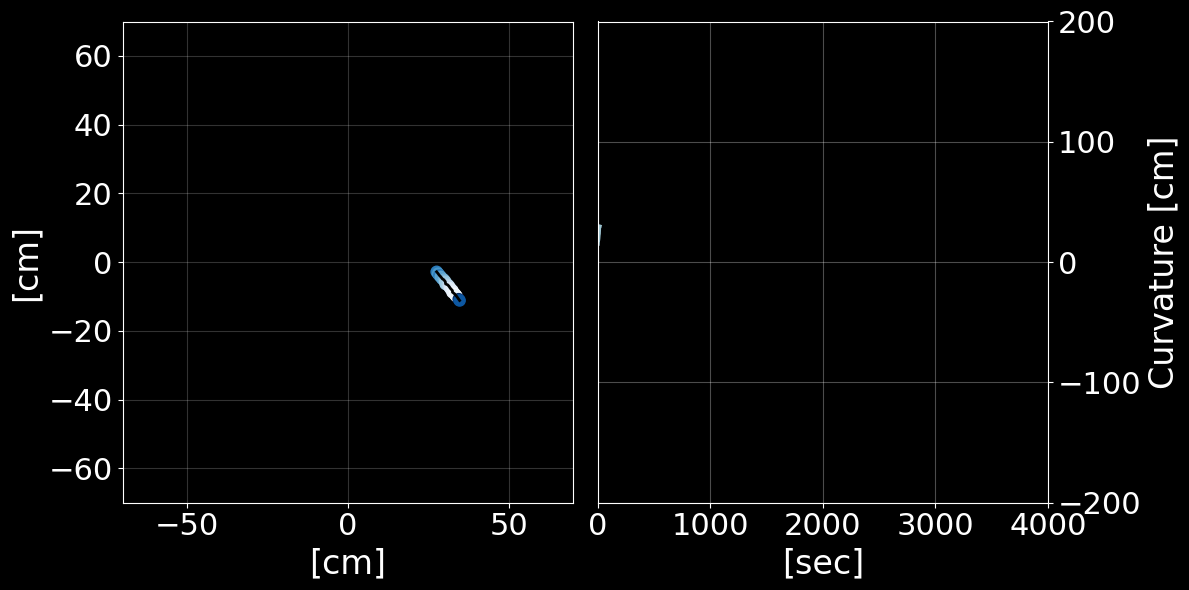

In [39]:
fig,ax = plt.subplots(1,2,figsize=(12,6))
#fig,ax = plt.subplots(1,1)
#X1 = X1[0:100]
#Y1 = Y1[0:100]
start=400
end=450
ax[0].scatter(X1,Y1,c=np.roll(1/np.abs(R1),-halfWindow),cmap='Blues',s=ppcx*6,alpha=1)
#ax[0].scatter(X2,Y2,c=np.roll(1/np.abs(R2),-halfWindow),cmap='Oranges',s=ppc*6,alpha=0.8)

ax[0].plot(X1,Y1,c='k',linewidth=2)#0.5)
#ax[0].plot(X2,Y2,c='k',linewidth=2)#0.5)
ax[0].axis([-70,70,-70,70])

ax[1].plot(t1New,R1new/ppcx,c='LightBlue',linewidth=3,alpha=0.9)
#ax[1].plot(t2New,R2new/ppc,c='Orange',linewidth=3,alpha=0.9)
ax[1].axis([0,4000,-200,200])
ax[1].grid(alpha=0.3)
print(len(R1new))

ax[0].set_xlabel('[cm]')
ax[0].grid(alpha=0.2)
ax[0].set_ylabel('[cm]')

ax[1].set_xlabel('[sec]')
ax[1].set_ylabel('Curvature [cm]')
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
#ax[0].text(62,5,'R = 11 cm',fontsize=24,color='LightBlue')
#ax[0].text(62,60,'R = -44 cm',fontsize=24,color='Orange')
fig.tight_layout()
fig.savefig('{}\curvature_figure_{}.png'.format(folder_name,linking_file_name))

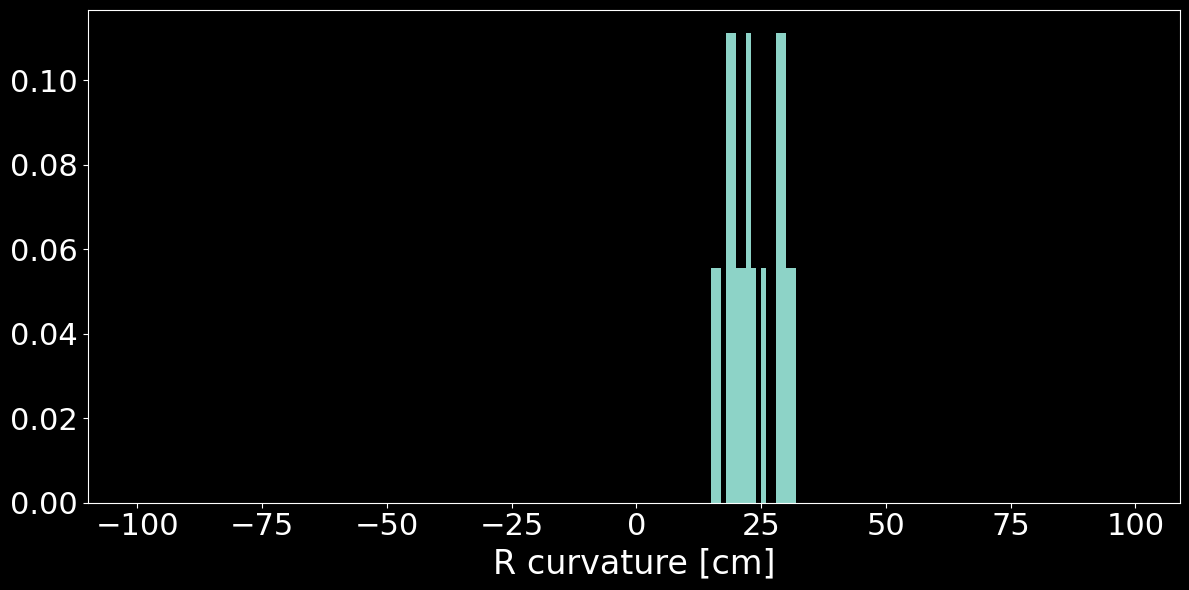

In [40]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
#ax.hist(R1_not_nan[~np.isinf(R1_not_nan)],bins=range(-5000,5000,10))
ax.hist(R1_current,bins=range(-100,100,1),density=True)
#ax.hist(R1_not_nan[~np.isinf(R1_not_nan)],bins='auto')
ax.set_xlabel('R curvature [cm]')
#ax.axis([-5000,5000,0,200])
fig.tight_layout()
fig.savefig('{}\histogram_R_figure_{}.png'.format(folder_name,linking_file_name))

In [41]:
R_ans=np.median(R1_current)
print(R_ans)
#c_ans_avg=1/R_ans
C1_not_nan=1/R1_current
C_ans=np.median(C1_not_nan)
C_arvg_ans=np.mean(C1_not_nan)
print(C_ans)
print(C_arvg_ans)
#Omega=np.median(vtheta)
#print(Omega)
#hist_data=np.histogram(R1_not_nan[~np.isinf(R1_not_nan)], bins=range(-5000,5000,10))
#peaks=find_peaks(hist_data[0],height=60)
#print(peaks)
#R_hist_data=hist_data[1]
#print(R_hist_data[peaks[0]])
#ans=np.mean(R_hist_data[peaks[0]])
#print(ans)
#hist_data[0]=np.append(hist_data[0],[0])
#print(len(hist_data[0]))
#print(len(hist_data[1]))
#hist_bins=np.delete(hist_data[1],-1)
#weight_avrage=np.average(hist_bins,weights=hist_data[0])
#print(weight_avrage)

22.55735559807139
0.04433169386931645
0.04487685018187846


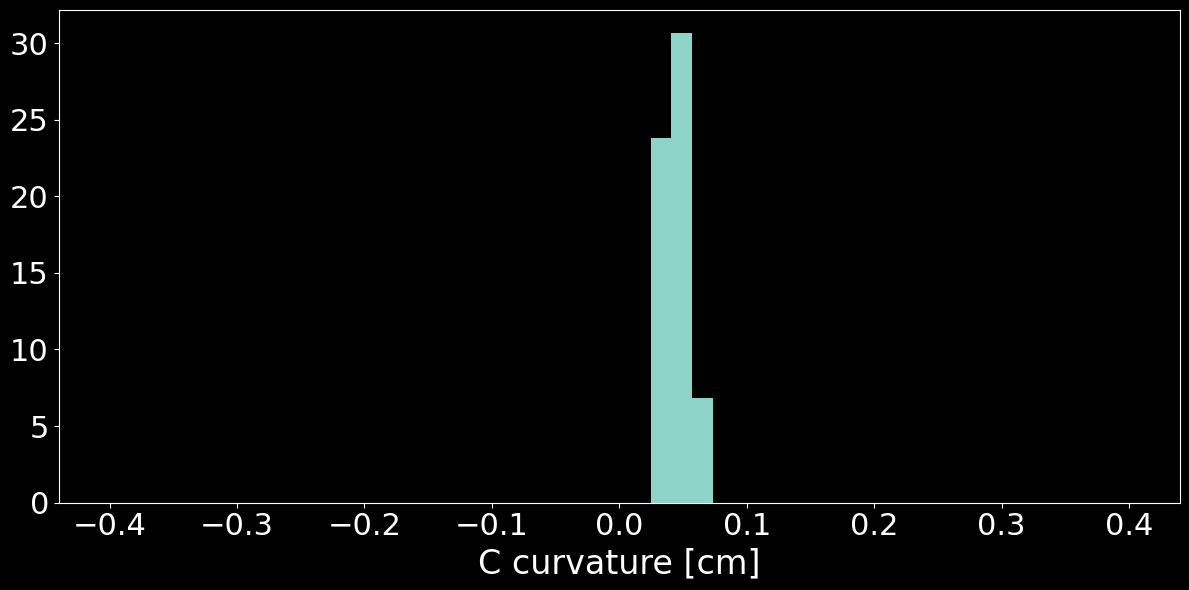

In [42]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
ax.hist(C1_not_nan,bins=np.linspace(-0.4,0.4,50),density=True)
#ax.hist(R1_not_nan[~np.isinf(R1_not_nan)],bins='auto')
ax.set_xlabel('C curvature [cm]')
#ax.axis([-1,1,0,25])
fig.tight_layout()
fig.savefig('{}\histogram_C_figure_{}.png'.format(folder_name,linking_file_name))

In [43]:
#fig,ax = plt.subplots(1,1,figsize=(12,6))
#ax.hist(vphi,bins=np.linspace(-0.4,0.4,100))
#ax.set_xlabel('Omega_0[rad/sec]')
#fig.tight_layout()
#fig.savefig('{}\Omega_histogram_{}.png'.format(folder_name,linking_file_name))

                         0
lag time [s]              
0.04          2.150659e+03
0.08          7.609704e+03
0.12          1.654995e+04
0.16          2.922597e+04
0.20          4.566563e+04
0.24          6.556977e+04
0.28          8.927643e+04
0.32          1.162281e+05
0.36          1.463588e+05
0.40          1.801012e+05
0.44          2.172882e+05
0.48          2.577112e+05
0.52          3.013816e+05
0.56          3.485809e+05
0.60          3.987996e+05
0.64          4.523850e+05
0.68          5.088187e+05
0.72          5.678204e+05
0.76          6.296829e+05
0.80          6.943020e+05
0.84          7.629236e+05
0.88          8.337559e+05
0.92          9.064409e+05
0.96          9.832337e+05
1.00          1.062871e+06
1.04          1.146130e+06
1.08          1.230553e+06
1.12          1.319579e+06
1.16          1.410856e+06
1.20          1.504345e+06
1.24          1.601520e+06
1.28          1.701776e+06
1.32          1.804645e+06
1.36          1.912160e+06
1.40          2.022500e+06
1

Text(0, 0.5, 'MSD $\\left[\\rm{cm}^2\\right]$')

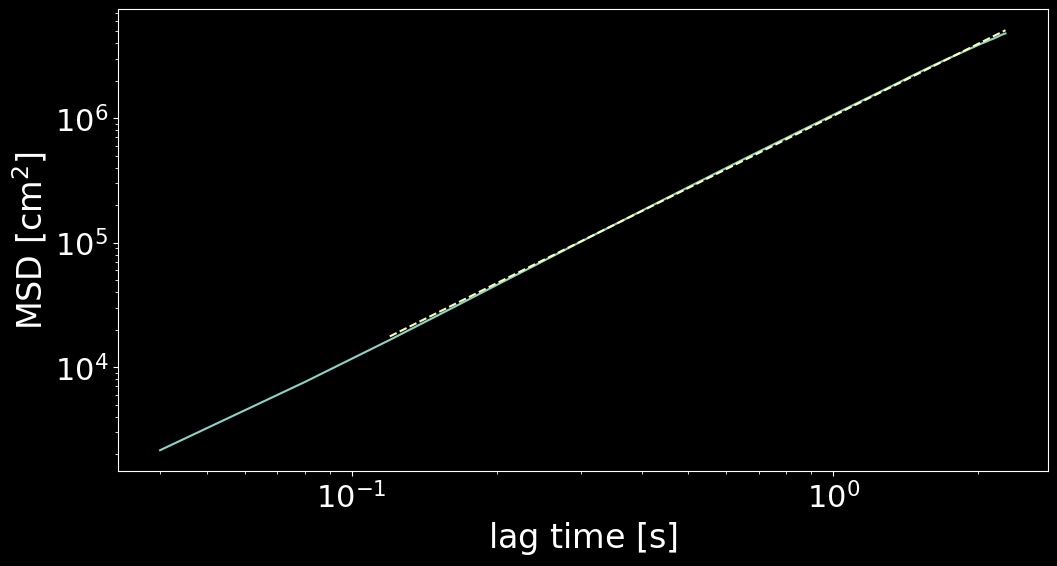

In [45]:
fig,ax = plt.subplots(1,1,figsize=(12,6))
fps=25
arenaSizePixelsx = 775#1080 # [pixels]
arenaSizePixelsy=1080
arenaSizeCm = 100#
mmp=arenaSizePixelsx/arenaSizeCm
relevant_data_try = tp.filter_stubs(tl,threshold=50)
#max_lagtime=int(len(relevant_data_try)/3)
imsd_try = tp.imsd(relevant_data_try,fps=fps,mpp=mmp,max_lagtime=300000)
print(imsd_try)
ax.loglog(imsd_try[(imsd_try>0)].index,imsd_try[imsd_try>0],label='msd')
#relevant_imsd=imsd_try.loc[0.1:3.4]
relevant_imsd=imsd_try.loc[0.1:3]
print(relevant_imsd)

p0=np.array([2,0.5])
popt,pcov = sc.optimize.curve_fit(linear_fit_log,np.log(relevant_imsd.index),np.log(relevant_imsd.iloc[:,0]),p0=p0)
perr = np.sqrt(np.diag(pcov))
corr=np.corrcoef(pcov,rowvar=True)
print(popt)
print(perr)
fit_x=np.log(relevant_imsd.index)
fit_y=fit_x*popt[0]+popt[1]
ax.loglog(np.exp(fit_x),np.exp(fit_y),'--')
ax.set_xlabel(r'lag time $\left[\rm{s}\right]$')
ax.set_ylabel(r'MSD $\left[\rm{cm}^2\right]$')

In [46]:
V0=np.sqrt(popt[1])
print(C_ans)
print(V0)
Omega_0=V0*C_ans
print(Omega_0)

0.04433169386931645
3.7225811091190826
0.16502832613316767


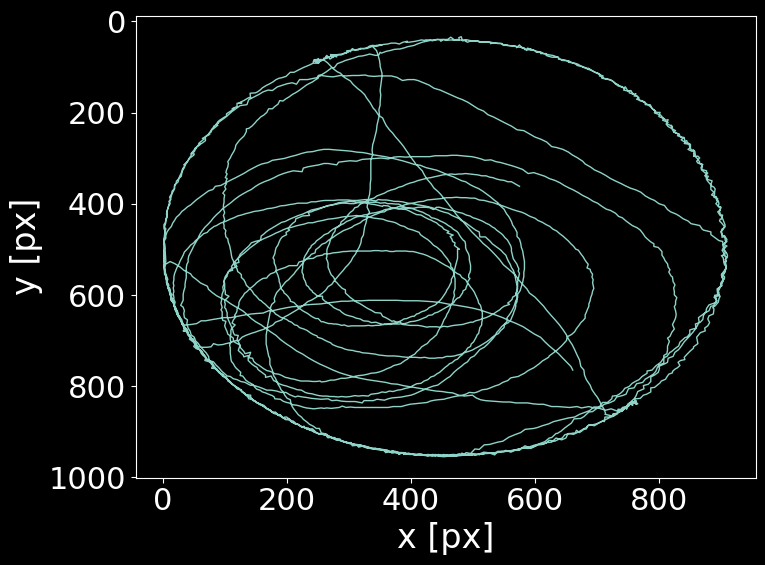

<AxesSubplot: xlabel='x [px]', ylabel='y [px]'>

In [654]:
tp.plot_traj(tl)

In [254]:
test=np.array([-np.inf,np.inf,-np.inf,np.inf,np.inf,7])
print(test)
print(np.sort(test))
print(np.median(test))
test2=1/test
print(test2)
print(np.sort(test2))
print(np.median(test2))

[-inf  inf -inf  inf  inf   7.]
[-inf -inf   7.  inf  inf  inf]
inf
[-0.          0.         -0.          0.          0.          0.14285714]
[-0.          0.         -0.          0.          0.          0.14285714]
0.0
